## Modelling the AR(1) on Revenue Growth for various sectors

In [1]:
!pip install statsmodels

In [3]:
import sys
from pathlib import Path

root_dir = Path.cwd().parent  # Go one folder up from /notebooks
print("Root directory:", root_dir)

if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))
    
import pandas as pd
df = pd.read_parquet("../data/enriched/financials_annual_ticker_sic.parquet")
df.head()

Root directory: /Users/agalyaayyadurai/Automated-Equity-Valuation


,adsh,cik,name,form,fy,fp,period,filed,sic,source_zip,...,WASODiluted,bs_diff,bs_balanced_flag,cf_delta_abs,cf_balanced_flag,coverage_score,WASOCombinedBasicDiluted,ticker,office,industry_title
0,0001047469-11-006302,1750,AAR CORP,10-K,2011,FY,20110531,2011-07-13,3720,2011q3,...,NaN,8.678820e+08,False,21964000.0,False,0.583333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS
1,0001047469-12-007300,1750,AAR CORP,10-K,2012,FY,20120531,2012-07-19,3720,2012q3,...,NaN,1.331004e+09,False,0.0,True,0.333333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS
2,0001047469-13-007797,1750,AAR CORP,10-K,2013,FY,20130531,2013-07-26,3720,2013q3,...,NaN,1.218300e+09,False,6400000.0,False,0.583333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS
3,0001047469-14-006243,1750,AAR CORP,10-K,2014,FY,20140531,2014-07-17,3720,2014q3,...,NaN,1.200000e+09,False,13000000.0,False,0.583333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS
4,0001047469-15-006136,1750,AAR CORP,10-K,2015,FY,20150531,2015-07-15,3720,2015q3,...,NaN,6.699000e+08,False,31900000.0,False,0.583333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS


In [4]:
# --- DATASET SCOPE ---

# Number of total filings (already known but recalculated)
total_rows = len(df)

# Number of unique companies
num_companies = df['cik'].nunique()

# Number of years represented
years = sorted(df['fy'].dropna().unique())
year_range = (min(years), max(years))

# Sector distribution (industry_title)
sector_counts = df['office'].value_counts(dropna=False)

print("Total filings:", total_rows)
print("Unique companies (CIK):", num_companies)
print("Year range:", year_range)
print("\nSector distribution:")
print(sector_counts)

Total filings: 89478
Unique companies (CIK): 13613
Year range: (2004, 2025)

Sector distribution:
office
Office of Manufacturing                                            12665
Office of Trade & Services                                         11993
Office of Real Estate & Construction                               10960
Office of Energy & Transportation                                  10890
Office of Finance                                                  10308
Office of Technology                                               10153
Industrial Applications and Services                                9202
Office of Life Sciences                                             8484
Office of Trade & Services or Office of Energy & Transportation     2097
Office of Crypto Assets                                             1378
Office of Finance or Office of Crypto Assets                         492
Office of Finance or Office of Crypto Assets                         456
None               

In [5]:
import numpy as np

# 1) Remove missing or non-positive revenue
df_sorted = df.dropna(subset=["Revenue"]).copy()
df_sorted = df_sorted[df_sorted["Revenue"] > 0].copy()
df_sorted = df_sorted.sort_values(by=['cik', 'fy'])
df_sorted['log_rev'] = np.log(df_sorted['Revenue'])
df_sorted['log_rev_growth'] = df_sorted.groupby('cik')['log_rev'].diff()

In [6]:
log_growth_stats = df_sorted['log_rev_growth'].dropna().describe()
from scipy.stats import skew
sk_val = skew(df_sorted['log_rev_growth'].dropna())

print(log_growth_stats)

print("\nSK_VAL:")      
print(sk_val)

count    50232.000000
mean         0.087765
std          0.891317
min        -13.662182
25%         -0.061030
50%          0.054545
75%          0.194585
max         15.272962
Name: log_rev_growth, dtype: float64

SK_VAL:
1.2976614829954394


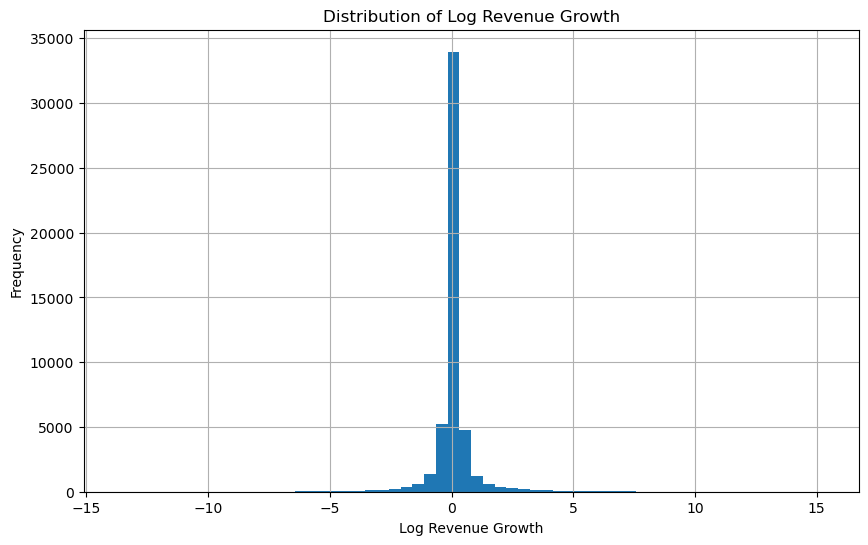

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df_sorted['log_rev_growth'].dropna().hist(bins=60)
plt.title("Distribution of Log Revenue Growth")
plt.xlabel("Log Revenue Growth")
plt.ylabel("Frequency")
plt.show()


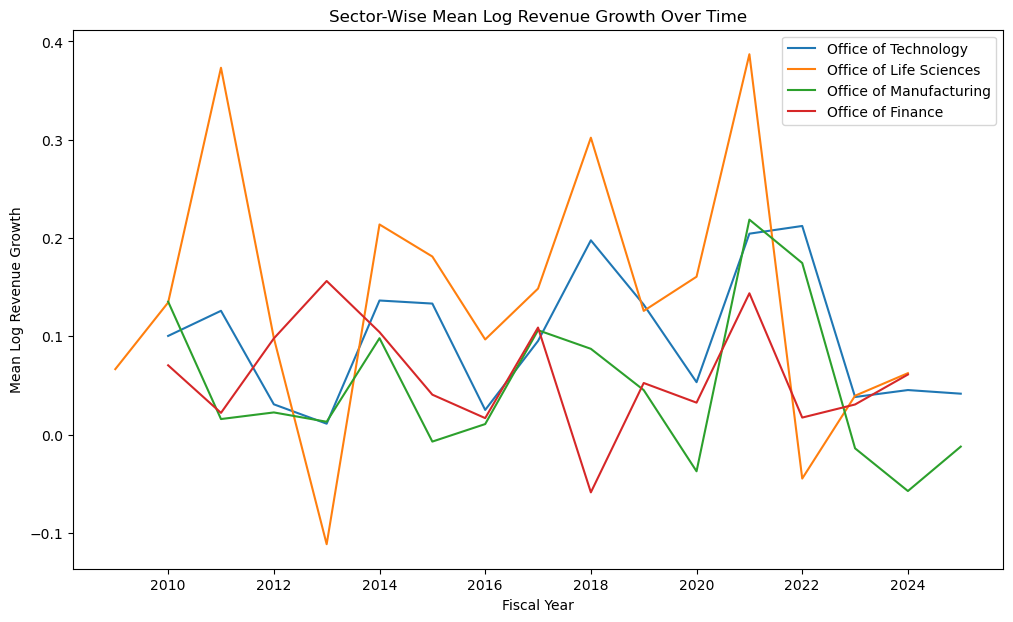

In [22]:
sector_growth = (
    df_sorted.groupby(['office', 'fy'])['log_rev_growth']
    .mean()
    .reset_index()
)

selected_sectors = [
    'Office of Technology',
    'Office of Life Sciences',   # Healthcare category
    'Office of Manufacturing',
    'Office of Finance'
]

plt.figure(figsize=(12,7))
for sec in selected_sectors:
    subset = sector_growth[sector_growth['office'] == sec]
    plt.plot(subset['fy'], subset['log_rev_growth'], label=sec)

plt.title("Sector-Wise Mean Log Revenue Growth Over Time")
plt.xlabel("Fiscal Year")
plt.ylabel("Mean Log Revenue Growth")
plt.legend()
plt.show()

In [7]:
# --- DATA CLEANING SUMMARY ---

# Missing values count
missing_summary = df.isnull().sum().sort_values(ascending=False)

# Firms removed (optional): count where revenue missing
firms_removed = df[df['Revenue'].isna()]['cik'].nunique()

print("Missing value summary (top 15 variables with most missing):")
print(missing_summary.head(15))

print("\nNumber of firms removed due to missing Revenue:", firms_removed)

print("\nFinal dataset size after removing missing Revenue rows:")
print(len(df.dropna(subset=['Revenue'])))

Missing value summary (top 15 variables with most missing):
TotalNoncurrentAssets       83770
ShortTermInvestments        81628
DebtIssuance                72259
ProceedsFromSalePPE         70776
WASOCombinedBasicDiluted    69192
DepAmort                    66282
RND                         65576
LongTermDebt                62720
TreasuryStock               62624
ShortTermDebt               62553
ShareRepurchase             59823
DebtRepayment               58165
GrossProfit                 57807
CostOfRevenue               56211
Inventory                   54139
dtype: int64

Number of firms removed due to missing Revenue: 7164

Final dataset size after removing missing Revenue rows:
62537


## Mean Reversion Tests

In [8]:
import numpy as np

# 1) Remove missing or non-positive revenue
df_cleaned = df.dropna(subset=["Revenue"]).copy()
df_cleaned = df_cleaned[df_cleaned["Revenue"] > 0].copy()

# 2) Ensure period is datetime (if not already)
df_cleaned["period"] = pd.to_datetime(df_cleaned["period"])

# 3) Sort for time-series ordering
df_cleaned = df_cleaned.sort_values(["cik", "period"]).copy()

# 4) Compute log revenue and lag
df_cleaned["log_rev"] = np.log(df_cleaned["Revenue"])
df_cleaned["log_rev_lag"] = df_cleaned.groupby("cik")["log_rev"].shift(1)

# 5) Compute log revenue growth g
df_cleaned["g"] = df_cleaned["log_rev"] - df_cleaned["log_rev_lag"]

# Keep only valid growth observations
df_cleaned = df_cleaned.dropna(subset=["g"]).copy()

# 6) Keep only CIKs with min 4 growth observations (≈ 5 years of data)
growth_counts = df_cleaned.groupby("cik")["g"].size()
valid_ciks = growth_counts[growth_counts >= 4].index
df_cleaned = df_cleaned[df_cleaned["cik"].isin(valid_ciks)].copy()

# 7) Build AR(1) input variable: g_lag
df_cleaned["g_lag"] = df_cleaned.groupby("cik")["g"].shift(1)
df_cleaned = df_cleaned.dropna(subset=["g_lag"]).copy()

df_cleaned.head()


,adsh,cik,name,form,fy,fp,period,filed,sic,source_zip,...,cf_balanced_flag,coverage_score,WASOCombinedBasicDiluted,ticker,office,industry_title,log_rev,log_rev_lag,g,g_lag
2,0001047469-13-007797,1750,AAR CORP,10-K,2013,FY,2013-05-31,2013-07-26,3720,2013q3,...,False,0.583333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS,21.482809,21.448395,0.034414,0.150888
3,0001047469-14-006243,1750,AAR CORP,10-K,2014,FY,2014-05-31,2014-07-17,3720,2014q3,...,False,0.583333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS,21.433762,21.482809,-0.049048,0.034414
4,0001047469-15-006136,1750,AAR CORP,10-K,2015,FY,2015-05-31,2015-07-15,3720,2015q3,...,False,0.583333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS,21.189701,21.433762,-0.244061,-0.049048
5,0001047469-16-014299,1750,AAR CORP,10-K,2016,FY,2016-05-31,2016-07-13,3720,2016q3,...,False,0.583333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS,21.231648,21.189701,0.041948,-0.244061
6,0001047469-17-004528,1750,AAR CORP,10-K,2017,FY,2017-05-31,2017-07-12,3720,2017q3,...,False,0.583333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS,21.292889,21.231648,0.061240,0.041948


In [27]:
import pandas as pd

def filter_and_tag_sectors(df: pd.DataFrame, sic_col: str = "sic"):
    """
    Filter a fundamentals DataFrame to selected SIC-based sectors/sub-sectors
    and add 'sector' and 'sub_sector' columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing at least the SIC code column.
    sic_col : str, default "SIC"
        Name of the column in df that contains the SIC code.

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame with two new columns: 'sector' and 'sub_sector'.
    """

    # --- 1. Define the sector / sub-sector structure by SIC code ---
    sector_structure = {
        "Technology & Communication": {
            # Core hardware & equipment
            "Electronic Computers": [3571],
            "Computer Storage Devices": [3572],
            "Computer & Office Equipment – Other": [3575, 3576, 3577, 3578, 3579],
    
            # Communications equipment & components
            "Radio & TV Broadcasting & Communications Equipment": [3661, 3663, 3669],
            "Electronic Components & Accessories": [3670, 3672, 3677, 3678, 3679],
            "Semiconductors & Related Devices": [3674],
    
            # Software & IT services
            "Prepackaged Software": [7372],
            "IT Services & Data Processing": [7370, 7371, 7373, 7374],
    
            # Telecom services
            "Telecom Services": [4812, 4813, 4899],
        },
    
        "Health Care & Life Sciences": {
            "Pharmaceutical Preparations": [2834],
            "Biological Products": [2836],
            "Diagnostic Substances (In Vitro & In Vivo)": [2835],
            "Surgical & Medical Instruments": [3841],
            "General Medical & Surgical Hospitals": [8062],
        },
    
        "Financials": {
            "National Commercial Banks": [6021],
            "State Commercial Banks": [6022],
            "Security Brokers & Dealers": [6211],
            "Investment Advice": [6282],
            "Real Estate Investment Trusts (REITs)": [6798],
        },
    
        "Consumer (Staples & Discretionary)": {
            # --- Staples (Defensive) ---
            "Retail – Grocery Stores": [5411],
            "Packaged Foods": [2030, 2050, 2090],       # Canned, bakery, misc foods
            "Soft Drinks & Carbonated Waters": [2086],
            "Household & Personal Care Products": [2842, 2844],  # Cleaning + cosmetics
    
            # --- General retail & e-commerce ---
            "General Merchandise & Department Stores": [5311, 5399],
            "E-Commerce / Nonstore Retail": [5960, 5961],
    
            # --- Foodservice / restaurants ---
            "Restaurants & Eating Places": [5812],
    
            # --- Apparel & shoes ---
            "Apparel & Clothing Stores": [5600, 5621, 5651],
            "Shoe Stores": [5661],
    
            # --- Home & furniture / building supplies ---
            "Home Furniture & Furnishings Stores": [5700, 5712],
            "Home Improvement & Building Materials (Retail)": [5200, 5211],
    
            # --- Autos & related retail ---
            "Automotive Manufacturing & Parts": [3711, 3713, 3714, 3715],
            "Auto Dealers & Service Stations": [5500, 5531],
    
            # --- Specialty & hobby retail ---
            "Retail – Hobby, Toy & Game Shops": [5945],
            "Consumer Electronics Stores": [5731],
    
            # --- Entertainment, leisure & recreation ---
            "Entertainment & Recreation Services": [7900, 7990, 7997, 7948],
            "Motion Picture & Video Exhibition & Rental": [7830, 7841],
            "Motion Picture & Video Production/Distribution": [7812, 7822, 7829],
    
            # --- Hotels & lodging ---
            "Hotels, Motels & Lodging": [7000, 7011],
        },
    
        "Energy, Utilities & Infrastructure": {
            # Upstream, midstream, downstream
            "Crude Petroleum & Natural Gas": [1311],
            "Oil & Gas Field Services & Equipment": [1381, 1382, 1389, 3533],
            "Coal & Consumable Fuels": [1220, 1221],
            "Petroleum Refining": [2911],
            "Pipelines (Excl. Natural Gas)": [4610],
    
            # Utilities & energy services
            "Electric Services": [4911],
            "Natural Gas Transmission & Distribution": [4922, 4923, 4924],
            "Electric & Other Services Combined": [4931],
            "Gas & Other Services Combined": [4932],
            "Electric, Gas & Sanitary Services – Other": [4900],
    
            # Waste, steam & cogeneration
            "Refuse & Waste Management": [4953, 4955],
            "Steam & Air-Conditioning Supply": [4961],
            "Cogeneration & Small Power Producers": [4991],
        },
    }



    # --- 2. Build lookup dicts: SIC -> sector, SIC -> sub_sector ---
    sic_to_sector = {}
    sic_to_sub = {}

    for sector, subs in sector_structure.items():
        for sub_name, sic_list in subs.items():
            for sic in sic_list:
                sic_to_sector[sic] = sector
                sic_to_sub[sic] = sub_name

    # --- 3. Normalize SIC column to numeric (in case it's string) ---
    df = df.copy()
    df[sic_col] = pd.to_numeric(df[sic_col], errors="coerce").astype("Int64")

    # --- 4. Filter to only the chosen SIC codes ---
    valid_sics = set(sic_to_sector.keys())
    mask = df[sic_col].isin(valid_sics)
    filtered = df[mask].copy()

    # --- 5. Map sector and sub_sector ---
    filtered["sector"] = filtered[sic_col].map(sic_to_sector)
    filtered["sub_sector"] = filtered[sic_col].map(sic_to_sub)

    return filtered


In [28]:
# Example: df_fundamentals already has columns like ['SIC', 'Office', 'Industry Title', ...]
filtered_df = filter_and_tag_sectors(df_cleaned, sic_col="sic")

# Now filtered_df:
# - only contains rows with the chosen SIC codes
# - has two new columns: 'sector' and 'sub_sector'

In [29]:
filtered_df["sector"].value_counts()

sector
Technology & Communication            5856
Health Care & Life Sciences           3985
Consumer (Staples & Discretionary)    3303
Financials                            3297
Energy, Utilities & Infrastructure    3224
Name: count, dtype: int64

In [20]:
unique_ciks_per_sub = (
    filtered_df
    .groupby("sub_sector")["cik"]
    .nunique()
    .reset_index(name="unique_cik_count")
    .sort_values("unique_cik_count", ascending=False)
)

print(unique_ciks_per_sub)


                                           sub_sector  unique_cik_count
17                        Pharmaceutical Preparations               981
18                               Prepackaged Software               581
20              Real Estate Investment Trusts (REITs)               497
3                       Crude Petroleum & Natural Gas               416
29                             State Commercial Banks               406
1                                 Biological Products               274
30                     Surgical & Medical Instruments               268
13                          National Commercial Banks               219
26                   Semiconductors & Related Devices               205
21                        Restaurants & Eating Places               120
14            Natural Gas Transmission & Distribution               119
7                                   Electric Services               113
5                   E-Commerce / Catalog & Mail Order           

In [30]:
filtered_df['has_revenue'] = filtered_df['Revenue'].notna().astype(int)

coverage = (
    filtered_df.groupby('sector')['has_revenue']
      .agg(records='count', with_revenue='sum')
      .assign(pct_with_revenue=lambda x: x['with_revenue'] / x['records'] * 100)
)

print(coverage)

                                    records  with_revenue  pct_with_revenue
sector                                                                     
Consumer (Staples & Discretionary)     3303          3303             100.0
Energy, Utilities & Infrastructure     3224          3224             100.0
Financials                             3297          3297             100.0
Health Care & Life Sciences            3985          3985             100.0
Technology & Communication             5856          5856             100.0


## Is Revenue growth mean reverting??

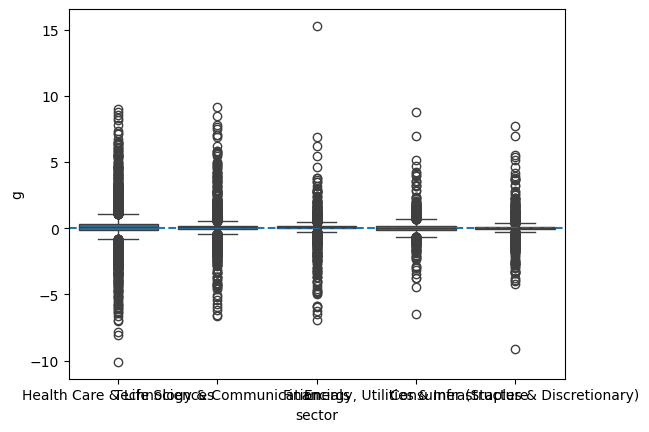

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=filtered_df, x="sector", y="g")
plt.axhline(0, linestyle="--")
plt.show()

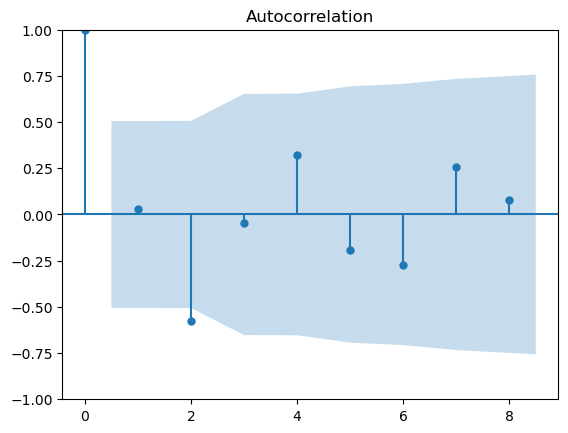

In [38]:
## Auto correlation function of growth

from statsmodels.graphics.tsaplots import plot_acf

# Example: sector-level average growth per year
df_acf = filtered_df.copy()
df_acf["year"] = df_acf["period"].dt.year

tech_yearly = (
    df_acf[df_acf["sector"] == "Technology & Communication"]
    .groupby("year")["g"].mean()
    .sort_index()
)

plot_acf(tech_yearly, lags=8)
plt.show()


In [9]:
# ADF and KPSS Tests

from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
import pandas as pd

def sector_stationarity_tests(df):
    df = df.copy()
    df["year"] = df["period"].dt.year

    results = []

    for sector, d in df.groupby("office"):
        # sector-level annual average growth
        ts = (
            d.groupby("year")["g"]
            .mean()
            .sort_index()
        ).dropna()

        if len(ts) < 8:  # not enough time points for a meaningful test
            continue

        # ADF: H0 = unit root (non-stationary)
        adf_stat, adf_p, _, _, adf_crit, _ = adfuller(ts, autolag="AIC")

        # KPSS: H0 = stationary
        try:
            kpss_stat, kpss_p, _, kpss_crit = kpss(ts, regression="c", nlags="auto")
        except ValueError:
            kpss_stat, kpss_p, kpss_crit = np.nan, np.nan, {}

        results.append({
            "office": sector,
            "n_years": len(ts),
            "adf_stat": adf_stat,
            "adf_pvalue": adf_p,
            "kpss_stat": kpss_stat,
            "kpss_pvalue": kpss_p,
        })

    return pd.DataFrame(results)

stationarity_results = sector_stationarity_tests(df_cleaned)
print(stationarity_results)


                                               office  n_years  adf_stat  \
0                Industrial Applications and Services       15 -0.847384   
1                             Office of Crypto Assets       14 -0.930680   
2                   Office of Energy & Transportation       15 -4.932471   
3                                   Office of Finance       15 -2.472128   
4        Office of Finance or Office of Crypto Assets       12 -1.611950   
5        Office of Finance or Office of Crypto Assets       15 -2.875391   
6                             Office of Life Sciences       15 -5.148670   
7                             Office of Manufacturing       15 -3.693626   
8                Office of Real Estate & Construction       15 -2.618392   
9                                Office of Technology       15 -5.490453   
10                         Office of Trade & Services       15 -2.720793   
11  Office of Trade & Services or Office of Energy...       15 -1.534230   

    adf_pva

/var/folders/zz/l0v68lmx1_1fxy9jgn7ynjkw0000gn/T/ipykernel_50620/1521018600.py:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(ts, regression="c", nlags="auto")
/var/folders/zz/l0v68lmx1_1fxy9jgn7ynjkw0000gn/T/ipykernel_50620/1521018600.py:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(ts, regression="c", nlags="auto")
/var/folders/zz/l0v68lmx1_1fxy9jgn7ynjkw0000gn/T/ipykernel_50620/1521018600.py:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(ts, regression="c", nlags="auto")
/var/folders/zz/l0v68lmx1

In [31]:
import statsmodels.api as sm

def estimate_ar1(df):
    results = []

    for sector, df_sec in df.groupby("sector"):
        X = sm.add_constant(df_sec["g_lag"])
        y = df_sec["g"]

        model = sm.OLS(y, X, missing="drop").fit()

        alpha = model.params["const"]
        phi = model.params["g_lag"]
        sigma = model.resid.std()

        # OU equivalents
        kappa = 1 - phi
        mu = alpha / kappa if kappa != 0 else np.nan

        results.append({
            "sector": sector,
            "alpha": alpha,
            "phi (persistence)": phi,
            "kappa (speed of mean reversion)": kappa,
            "mu (long-run mean growth)": mu,
            "sigma (volatility)": sigma,
            "n_obs": len(df_sec),
            "n_cik": df_sec["cik"].nunique()
        })

    return pd.DataFrame(results)

sector_params = estimate_ar1(filtered_df)
sector_params

,sector,alpha,phi (persistence),kappa (speed of mean reversion),mu (long-run mean growth),sigma (volatility),n_obs,n_cik
0,Consumer (Staples & Discretionary),0.047582,-0.054916,1.054916,0.045105,0.567234,3303,447
1,"Energy, Utilities & Infrastructure",0.038231,-0.011460,1.011460,0.037797,0.560461,3224,435
2,Financials,0.050781,-0.008363,1.008363,0.050360,0.698980,3297,470
3,Health Care & Life Sciences,0.147182,-0.227077,1.227077,0.119945,1.241660,3985,597
4,Technology & Communication,0.088234,-0.118181,1.118181,0.078909,0.692015,5856,819


In [33]:
# subsector ar(1). modelling
def estimate_subsector_ar1(growth_panel):
    """
    Estimate AR(1) and OU parameters for each sub-sector.
    Returns a ranking of sub-sectors by persistence, mean reversion, volatility, etc.
    """

    results = []

    for (sector, subsec), df_ss in growth_panel.groupby(["sector", "sub_sector"]):

        if len(df_ss) < 50:  # avoid unstable regressions
            continue

        # AR(1) regression: g_t = alpha + phi * g_{t-1}
        X = sm.add_constant(df_ss["g_lag"])
        y = df_ss["g"]
        model = sm.OLS(y, X, missing="drop").fit()

        alpha = model.params["const"]
        phi   = model.params["g_lag"]
        sigma = model.resid.std()

        # OU equivalents
        kappa = 1 - phi
        mu = alpha / kappa if kappa != 0 else np.nan

        results.append({
            "sector": sector,
            "sub_sector": subsec,
            "alpha": alpha,
            "phi (persistence)": phi,
            "kappa (speed of MR)": kappa,
            "mu (long-run growth)": mu,
            "sigma (volatility)": sigma,
            "n_obs": len(df_ss),
            "n_cik": df_ss["cik"].nunique()
        })

    return pd.DataFrame(results).sort_values(by="sector")

subsector_ar1_results = estimate_subsector_ar1(filtered_df)
subsector_ar1_results

,sector,sub_sector,alpha,phi (persistence),kappa (speed of MR),mu (long-run growth),sigma (volatility),n_obs,n_cik
0,Consumer (Staples & Discretionary),Apparel & Clothing Stores,0.020219,-0.734502,1.734502,0.011657,0.346968,284,30
15,Consumer (Staples & Discretionary),Soft Drinks & Carbonated Waters,0.088355,-0.129002,1.129002,0.078259,0.293245,68,10
14,Consumer (Staples & Discretionary),Retail – Grocery Stores,0.034337,0.181097,0.818903,0.041931,0.103930,81,13
13,Consumer (Staples & Discretionary),Restaurants & Eating Places,0.050340,0.178847,0.821153,0.061304,0.421352,499,64
12,Consumer (Staples & Discretionary),Packaged Foods,-0.016165,0.293001,0.706999,-0.022864,0.539099,126,19
11,Consumer (Staples & Discretionary),Motion Picture & Video Production/Distribution,0.125983,-0.014122,1.014122,0.124228,1.218094,82,13
10,Consumer (Staples & Discretionary),Motion Picture & Video Exhibition & Rental,0.054163,-0.172737,1.172737,0.046185,0.411131,94,10
8,Consumer (Staples & Discretionary),"Hotels, Motels & Lodging",0.054878,-0.072235,1.072235,0.051181,0.316299,306,44
9,Consumer (Staples & Discretionary),Household & Personal Care Products,0.052176,-0.080561,1.080561,0.048286,0.657017,177,26
6,Consumer (Staples & Discretionary),Home Furniture & Furnishings Stores,-0.000631,0.645387,0.354613,-0.001780,0.129732,79,10
